In [1]:
import networkx as nx

In [2]:
G = nx.Graph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_edge('A', 'B')
G.add_edge('B', 'C')
G.add_edge('A', 'C')
G.add_edge('C', 'D')

In [3]:
G.number_of_nodes(), G.number_of_edges()

(4, 4)

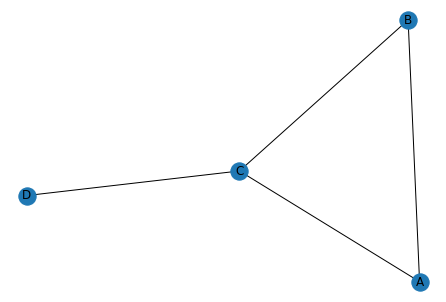

In [4]:
nx.draw(G, with_labels=True)

In [5]:
H = nx.Graph()
H.add_node('E')
H.add_node('F')
H.add_node('G')
H.add_node('H')
H.add_edge('E', 'F')
H.add_edge('F', 'G')
H.add_edge('G', 'H')

In [6]:
H.number_of_nodes(), H.number_of_edges()

(4, 3)

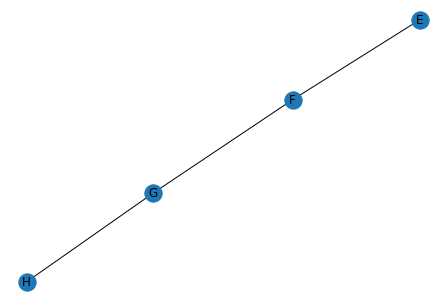

In [7]:
nx.draw(H, with_labels=True)

In [8]:
U = nx.cartesian_product(G, H)

In [9]:
U.number_of_nodes(), U.number_of_edges()

(16, 28)

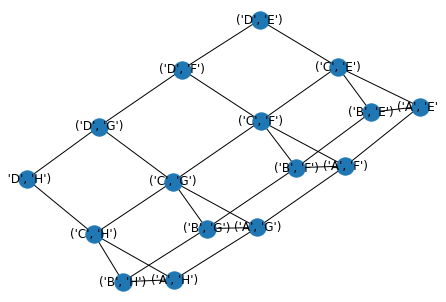

In [10]:
nx.draw(U, with_labels=True)

In [11]:
R = nx.full_join(G, H)

In [12]:
R.number_of_nodes(), R.number_of_edges()

(8, 23)

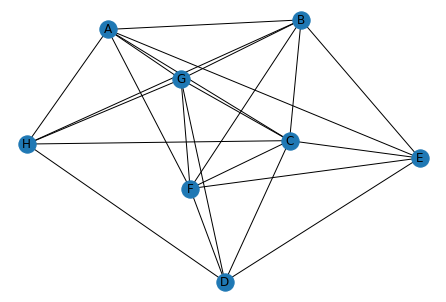

In [13]:
nx.draw(R, with_labels=True)

In [14]:
nx.adjacency_matrix(R).toarray()

array([[0, 1, 1, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 1, 0]])

In [15]:
R.edges()

EdgeView([('A', 'B'), ('A', 'C'), ('A', 'E'), ('A', 'F'), ('A', 'G'), ('A', 'H'), ('B', 'C'), ('B', 'E'), ('B', 'F'), ('B', 'G'), ('B', 'H'), ('C', 'D'), ('C', 'E'), ('C', 'F'), ('C', 'G'), ('C', 'H'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('D', 'H'), ('E', 'F'), ('F', 'G'), ('G', 'H')])